In [3]:
import os
import pandas as pd

def load_all_data(folder_path):
    
    # Create an empty list to store DataFrames for each file
    dataframes = []

    # Loop through all CSV files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)

            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)

            # Correct timestamp
            df['timestamp_tz'] = pd.to_datetime(df['timestamp_tz'], errors='coerce')
            df['timestamp_tz'] = df['timestamp_tz'].dt.floor('s')

            # Drop rows with missing values in the 'timestamp_tz' column,
            df.dropna(subset=['timestamp_tz'], inplace=True)

            # Drop specified columns
            columns_to_drop = ['coil_reversed', 'device', 'channel', 'hz', 'firmware', 'timestamp',
                               'hour', 'Unnamed: 0.1', 'Unnamed: 0', 'event_id']
            df = df.drop(columns=columns_to_drop)

            # Assign a column with the name of the file (e.g., sensor_0, sensor_1, etc.)
            df['sensor_name'] = os.path.splitext(file_name)[0]

            # Append the cleaned DataFrame to the list
            dataframes.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dataframes, ignore_index=True)
    # converting wh to kwh
    combined_df['energy'] = combined_df['energy'] / 1000

    return combined_df


In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

def show_all_features(df, features, sensor_names):
    for feature in features:
        fig, ax = plt.subplots(figsize=(12, 6))

        for sensor_name in sensor_names:
            # To avoid SettingWithCopyWarning
            sensor_df = df[df['sensor_name'] == sensor_name].copy()

            # Sort the DataFrame by timestamp
            sensor_df = sensor_df.sort_values(by='timestamp_tz')

            # Compute cumulative energy
            sensor_df['cumulative_energy'] = sensor_df['energy'].cumsum()

            # Drop rows with missing 'timestamp_tz' or 'cumulative_energy' values
            sensor_df = sensor_df.dropna(subset=['timestamp_tz', 'cumulative_energy'])

            # Create an array of dates at 1:00 AM, 7:00 AM, 1:00 PM, and 7:00 PM each day
            date_ranges = pd.date_range(sensor_df['timestamp_tz'].dt.floor('D').min(), sensor_df['timestamp_tz'].dt.floor('D').max(), freq='D')
            x_ticks = np.concatenate([
                date_ranges + pd.DateOffset(hours=1),
                date_ranges + pd.DateOffset(hours=7),
                date_ranges + pd.DateOffset(hours=13),
                date_ranges + pd.DateOffset(hours=19),
            ])

            # Plot the cumulative energy consumption against time
            plt.plot(sensor_df['timestamp_tz'], sensor_df['cumulative_energy'], label=f'{sensor_name} Cumulative Energy')

        ax.set_xticks(x_ticks)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%I %p"))
        plt.title(f'Cumulative Energy vs. Time for All Sensors')
        plt.xlabel('Time')
        plt.ylabel('Cumulative Energy (kWh)')
        plt.xticks(rotation=45)

        # Add vertical lines at 1 AM each day (colored green)
        for date in date_ranges:
            plt.axvline(date + pd.DateOffset(hours=1), color='green', linestyle='--', linewidth=1)

        plt.legend(loc='best')
        plt.grid(True)
        plt.show()


In [4]:
folder_path = 'data_set_1'
df = load_all_data(folder_path)

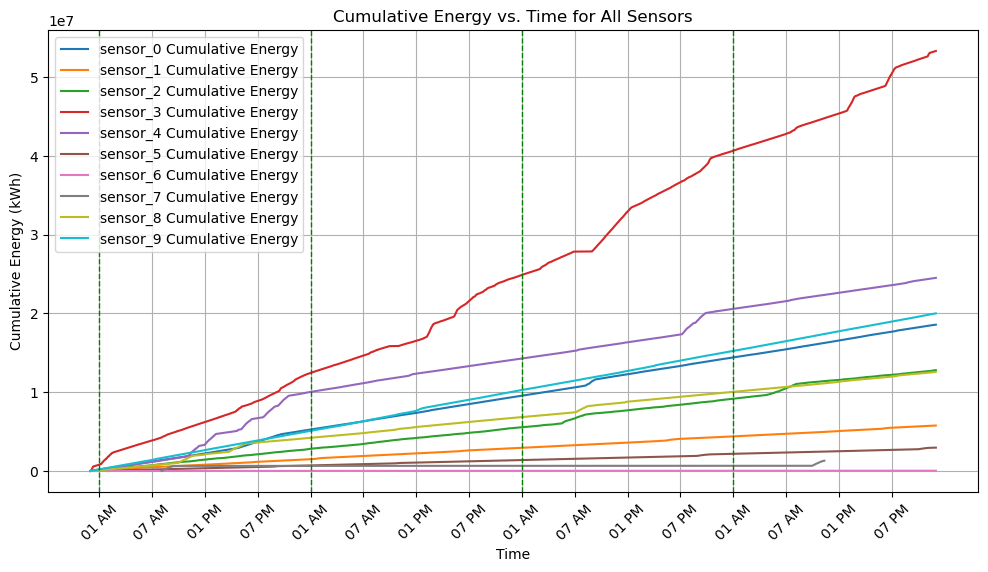

In [5]:
#List of sensor names to visualize
sensor_names = ['sensor_0', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7',
               'sensor_8', 'sensor_9']

# List of features to plot
features_to_plot = ['energy']

show_all_features(df, features_to_plot, sensor_names)